# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tf.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    x_scaled = StandardScaler().fit_transform(x.values)    
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = np_utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map)

def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def split_data(df, divisor):
    df_tot = df.copy()
    print(f'df_tot count : {len(df_tot)}')

    df1 = df_tot.iloc[int(len(df_tot)/divisor):]
    print(f'df1 count : {len(df1)}')

    df2 = df_tot.iloc[:int(len(df_tot)/divisor)]
    print(f'df2 count : {len(df2)}')
    
    return(df_tot, df1, df2)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map)

## Read Data

In [3]:
df = pd.read_csv('data/tab_tick_2019.csv')
df.head(5)

,tick_avg,spread_avg,tick_sd,tick_diff,sema,lema,ema_diff,ssma,lsma,sma_diff,diff,gain,loss,avg_gain,avg_loss,rs,rsi,small_sema_slope,long_sema_slope,direction
0,1.146315,0.000191,0.000034,-0.000032,1.146333,1.146333,-3.855949e-07,1.146334,1.146359,-0.000025,-4.057722e-06,0.0,4.057722e-06,0.000002,7.072830e-07,2.343522,70.091415,7.069366,-13.017403,same
1,1.146318,0.000255,0.000009,0.000003,1.146330,1.146333,-2.802906e-06,1.146333,1.146358,-0.000025,-2.774500e-06,0.0,2.774500e-06,0.000001,9.054616e-07,1.550279,60.788604,4.964546,-12.938307,same
2,1.146327,0.000213,0.000010,0.000009,1.146329,1.146333,-3.293461e-06,1.146332,1.146357,-0.000025,-6.336818e-07,0.0,6.336818e-07,0.000001,7.363134e-07,1.906414,65.593338,2.961423,-12.929473,same
3,1.146279,0.000273,0.000016,-0.000047,1.146320,1.146331,-1.115130e-05,1.146327,1.146355,-0.000028,-9.063921e-06,0.0,9.063921e-06,0.000001,1.240777e-06,1.131322,53.080768,-1.558345,-12.794593,decrease
4,1.146262,0.000340,0.000007,-0.000018,1.146310,1.146330,-2.017773e-05,1.146320,1.146353,-0.000032,-1.059775e-05,0.0,1.059775e-05,0.000001,1.997759e-06,0.533668,34.796833,-8.822273,-12.624174,same


In [4]:
target_col = 'direction'
x_scaled, y_encoded, y_map = data_prep(df)

Record count : 99901
--------------------------
same        62104
increase    18940
decrease    18857
Name: direction, dtype: int64
--------------------------
same        0.621655
increase    0.189588
decrease    0.188757
Name: direction, dtype: float64


## Neural Network

### Network building

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

In [6]:
model = Sequential([
    Dense(units = 16, activation='relu', input_shape=[len(train_x[0])]),
    Dense(units = 32, activation='relu'),
    Dense(units = 64, activation='relu'),
    Dense(units = 32, activation='relu'),
    Dense(units = 16, activation='relu'),
    Dense(units = 3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),    
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 51        
Total params: 5,635
Trainable params: 5,635
Non-trainable params: 0
______________________________________________________

### Training

In [7]:
epoch_val         = 10
batch_size_val    = 1024

verbose_val       = 2
workers_val       = -1

In [8]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
         verbose=verbose_val)

Epoch 1/10
79/79 - 1s - loss: 0.7400 - accuracy: 0.6882 - val_loss: 0.4824 - val_accuracy: 0.8066
Epoch 2/10
79/79 - 1s - loss: 0.4564 - accuracy: 0.8167 - val_loss: 0.4396 - val_accuracy: 0.8191
Epoch 3/10
79/79 - 1s - loss: 0.4360 - accuracy: 0.8241 - val_loss: 0.4326 - val_accuracy: 0.8201
Epoch 4/10
79/79 - 1s - loss: 0.4298 - accuracy: 0.8254 - val_loss: 0.4278 - val_accuracy: 0.8233
Epoch 5/10
79/79 - 1s - loss: 0.4256 - accuracy: 0.8262 - val_loss: 0.4239 - val_accuracy: 0.8251
Epoch 6/10
79/79 - 1s - loss: 0.4235 - accuracy: 0.8272 - val_loss: 0.4224 - val_accuracy: 0.8259
Epoch 7/10
79/79 - 1s - loss: 0.4217 - accuracy: 0.8281 - val_loss: 0.4216 - val_accuracy: 0.8276
Epoch 8/10
79/79 - 1s - loss: 0.4191 - accuracy: 0.8292 - val_loss: 0.4206 - val_accuracy: 0.8269
Epoch 9/10
79/79 - 1s - loss: 0.4184 - accuracy: 0.8289 - val_loss: 0.4220 - val_accuracy: 0.8248
Epoch 10/10
79/79 - 1s - loss: 0.4180 - accuracy: 0.8291 - val_loss: 0.4192 - val_accuracy: 0.8266


### DNN Validation

In [9]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.81      0.71      0.76      3821
    increase       0.79      0.72      0.76      3743
        same       0.84      0.90      0.87     12417

    accuracy                           0.83     19981
   macro avg       0.81      0.77      0.79     19981
weighted avg       0.83      0.83      0.82     19981



### DNN Prediction

In [10]:
df1 = pd.read_csv('data/tab_tick_2018.csv')

#df1 = df1[col_list]
x_scaled1, y_encoded1, y_map1 = data_prep(df1, apply_smote = False)

predictions = model.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
df1.to_csv('data/tab_tick_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

Record count : 99901
--------------------------
same        48793
increase    25620
decrease    25488
Name: direction, dtype: int64
--------------------------
same        0.488414
increase    0.256454
decrease    0.255133
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.86      0.62      0.72     25488
    increase       0.88      0.59      0.71     25620
        same       0.69      0.91      0.78     48793

    accuracy                           0.75     99901
   macro avg       0.81      0.71      0.74     99901
weighted avg       0.78      0.75      0.75     99901



In [11]:
df1.head()

,tick_avg,spread_avg,tick_sd,tick_diff,sema,lema,ema_diff,ssma,lsma,sma_diff,...,gain,loss,avg_gain,avg_loss,rs,rsi,small_sema_slope,long_sema_slope,direction,predictions
0,1.201482,0.000157,0.000007,1.000000e-05,1.201457,1.201171,0.000286,1.201439,1.201024,0.000414,...,0.000006,0.0,0.000003,0.000005,0.620149,38.277283,-24.468222,36.156279,same,same
1,1.201481,0.000178,0.000002,-5.000000e-07,1.201461,1.201178,0.000283,1.201441,1.201027,0.000413,...,0.000004,0.0,0.000003,0.000005,0.639789,39.016561,-11.820742,37.596694,same,same
2,1.201483,0.000176,0.000002,2.000000e-06,1.201465,1.201185,0.000280,1.201448,1.201034,0.000414,...,0.000004,0.0,0.000003,0.000005,0.638914,38.983976,-0.274442,38.488405,same,same
3,1.201496,0.000173,0.000010,1.350000e-05,1.201471,1.201192,0.000279,1.201455,1.201044,0.000412,...,0.000006,0.0,0.000003,0.000005,0.662203,39.838872,10.405255,39.028280,same,same
4,1.201492,0.000158,0.000010,-4.500000e-06,1.201475,1.201199,0.000276,1.201462,1.201051,0.000411,...,0.000004,0.0,0.000002,0.000005,0.540048,35.066958,18.440327,39.492326,same,same


## RF Results

In [12]:
%%time
clf = RandomForestClassifier(n_jobs=-1) 
clf.fit(train_x, train_y)
predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.79      0.73      0.76      3821
    increase       0.80      0.71      0.76      3743
        same       0.85      0.89      0.87     12417

    accuracy                           0.83     19981
   macro avg       0.81      0.78      0.79     19981
weighted avg       0.83      0.83      0.83     19981

Wall time: 12.8 s


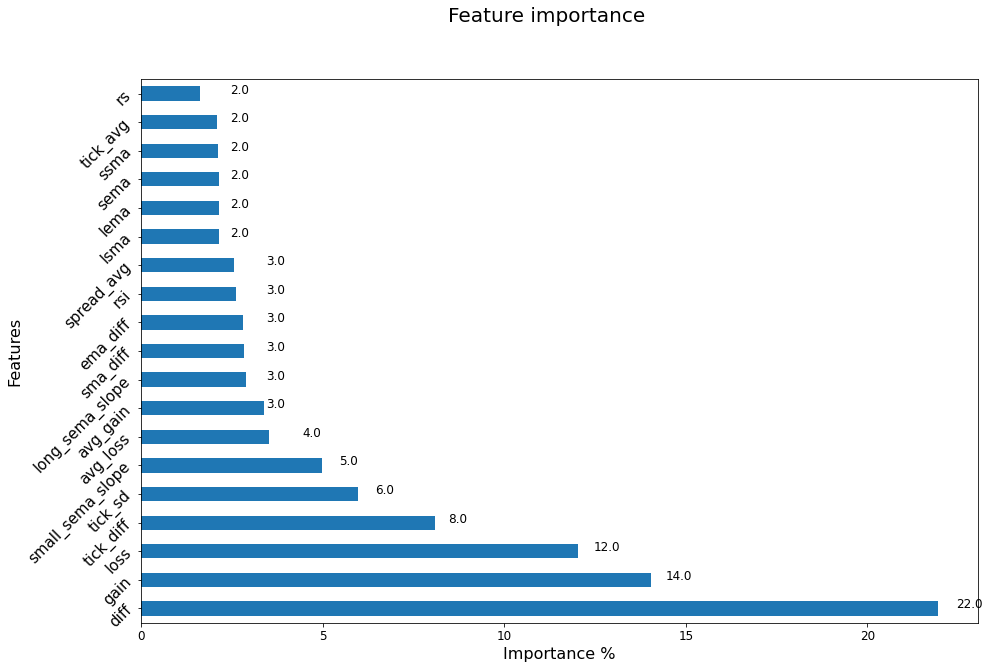

In [13]:
x_cols = df.columns[df.columns != 'direction']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(24).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(value+0.45, index, str(value), fontsize=12)